In [1]:
import pandas as pd
from torch.utils.data import Dataset
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import regex as re
import time
from multiprocessing import Pool
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from transformers import BertModel
from torch.nn import functional as F
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
class HateSpeechDS(Dataset):
    def __init__(self, path):
        self.path = path
        self.stop_words = stopwords.words("english")
        self.lemmatizer = WordNetLemmatizer()
        self.df = self.preprocess_df()
        self.punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

    def preprocess_df(self):
        df = pd.read_csv(self.path)
        desired_cols = ['tweet', 'class']
        label_map = {'hate_speech': 1, 'offensive_language': 1, 'neither': 0}
        df = df[desired_cols].copy()
        df['class'] = df['class'].replace(label_map)
        df['class'] = df['class'].replace({2:0})
        return df

    def process_text(self, text):
        modified_text = text.split(":")
        if len(modified_text) > 1: text = "".join(modified_text[1:])
        else : text = modified_text[0]
        text = " ".join(text.split())
        text = str(text).lower()
        text = re.sub("[\.\,\!\?\:\;\-\=]", " ", text)
        pattern = r"^\s*"
        text = re.sub(pattern, "", text)
        text = re.sub('\rt:/g',' ',text)#r
        text = re.sub('https?://\S+|www\.\S+', '', text)#urls
        text = re.sub('\w*\d\w*', '', text)#digits
        text = re.sub('<.*?>+', '', text)
        text = re.sub('[%s]' % re.escape(self.punctuation), '', text)
        text = re.sub('\n', '', text)
        ## remove retweets
        text = re.sub('(rt\: )|(rt\:)|(rt \: )|(rt )', ' ', text)
        text = [word for word in text.split(' ') if word not in self.stop_words]
        text =" ".join(text)
        text = [self.lemmatizer.lemmatize(word) for word in text.split(' ')]
        text =" ".join(text).lstrip()
        return text

    def transform_df(self, num_workers = 4):
        with Pool(processes=num_workers) as pool:
            processed_tweets = pool.map(self.process_text, self.df['tweet'].tolist())
        self.df['tweet'] = processed_tweets

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return list(self.df.iloc[idx, :])

In [4]:
class HateSpeechData(Dataset):
    def __init__(self, data):
        self.data = data
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data.iloc[idx, :]

        text = data["tweet"]
        label = data["class"]
        text_encoding = self.tokenizer.encode_plus(text, padding='max_length', truncation=True, max_length=64, return_tensors='pt')
        return {
            "input_ids": text_encoding["input_ids"].squeeze(0),
            "attention_mask": text_encoding["attention_mask"], ##.unsqueeze(0).int(),
            "label": label,
        }

In [5]:
def dataloader(dataset, batch_size = 32):
    return DataLoader(dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
            #converting numpy arrays to torch arrays
            collate_fn=lambda x: {
                "input_ids": torch.stack([item["input_ids"] for item in x]),
                "attention_mask": torch.stack([item["attention_mask"] for item in x]),
                "labels": torch.tensor([item["label"] for item in x])
            },
            pin_memory=True,
)


def load(path = "/workspaces/Hate-Speech-Detection/data/labeled_data.csv", df = None, test = False):
    # load the tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    dataset = HateSpeechDS(path)
    dataset.transform_df()
    data = dataset.df
    if test == False:
      train, validation = train_test_split(data, test_size=0.3, stratify=data['class'], random_state=42)
      dataset_train = HateSpeechData(train)
      dataset_val = HateSpeechData(validation)
      train_dataloader = dataloader(dataset_train)
      val_dataloader = dataloader(dataset_val)
      return train_dataloader, val_dataloader
    else:
      dataset_test = HateSpeechData(df)
      test_dataloader = dataloader(dataset_test)
      return test_dataloader

In [6]:
class BERTClassifier(nn.Module):

    def __init__(self):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(self.bert.config.hidden_size, 1)
        self.dropout = nn.Dropout(0.1)
        for n, p in self.bert.named_parameters():
            p.requires_grad = False

    def forward(self, text, masks):
        output_bert = self.bert(text, attention_mask=masks).last_hidden_state
        output_bert = self.avg_pool(output_bert.transpose(1, 2)).squeeze(-1)

        return self.linear(self.dropout(output_bert))

In [8]:
model = BERTClassifier()
train_loader, val_loader = load(path = "/content/drive/MyDrive/dataset/labeled_data.csv")
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
epochs = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

val_losses = []
train_losses = []

for epoch_i in range(0, epochs):

  model.train()
  print(f"Start training epoch {epoch_i}...")
  total_train_loss = 0
  for i, batch in enumerate(tqdm(train_loader)):
      optimizer.zero_grad()
      input_ids = batch['input_ids'].to(device)
      masks = batch['attention_mask'].to(device)
      label = batch['labels'].to(device)
      output = model(input_ids, masks)
      loss = criterion(output.squeeze(), label.float())
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()
      total_train_loss += loss.item()
  avg_train_loss = total_train_loss / len(train_loader)
  train_losses.append(avg_train_loss)
  model.eval()
  print("Start validation...")
  y_true_bert = list()
  y_pred_bert = list()

  total_eval_loss = 0.0
  with torch.no_grad():
      for batch in val_loader:
          input_ids = batch['input_ids'].to(device)
          masks = batch['attention_mask'].to(device)
          label = batch['labels'].to(device)

          output = model(input_ids, masks)
          max_output = (torch.sigmoid(output).cpu().numpy().reshape(-1)>= 0.5).astype(int)
          y_true_bert.extend(label.tolist())
          y_pred_bert.extend(max_output.tolist())

          loss_v = criterion(output.squeeze(), label.float())
          total_eval_loss += loss.item()
  avg_val_loss = total_eval_loss / len(val_loader)
  val_losses.append(avg_val_loss)

  print(f"Metrics after Epoch {epoch_i}")
  print(f"Accuracy : {accuracy_score(y_true_bert, y_pred_bert)}")
  print(f"Presision: {np.round(precision_score(y_true_bert, y_pred_bert),3)}")
  print(f"Recall: {np.round(recall_score(y_true_bert, y_pred_bert),3)}")
  print(f"F1: {np.round(f1_score(y_true_bert, y_pred_bert),3)}")
  print("   ")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Start training epoch 0...


100%|██████████| 543/543 [01:03<00:00,  8.62it/s]

Start validation...


Metrics after Epoch 0
Accuracy : 0.8402151983860121
Presision: 0.852
Recall: 0.961
F1: 0.903
   
Start training epoch 1...


100%|██████████| 543/543 [01:06<00:00,  8.20it/s]

Start validation...


Metrics after Epoch 1
Accuracy : 0.8497646267652993
Presision: 0.867
Recall: 0.952
F1: 0.907
   
Start training epoch 2...


100%|██████████| 543/543 [01:05<00:00,  8.24it/s]

Start validation...


Metrics after Epoch 2
Accuracy : 0.8512441156691325
Presision: 0.868
Recall: 0.953
F1: 0.908
   
Start training epoch 3...


100%|██████████| 543/543 [01:06<00:00,  8.21it/s]

Start validation...


Metrics after Epoch 3
Accuracy : 0.8537995965030263
Presision: 0.867
Recall: 0.958
F1: 0.91
   
Start training epoch 4...


100%|██████████| 543/543 [01:06<00:00,  8.21it/s]

Start validation...


Metrics after Epoch 4
Accuracy : 0.854472091459314
Presision: 0.863
Recall: 0.966
F1: 0.911
   
Start training epoch 5...


100%|██████████| 543/543 [01:06<00:00,  8.20it/s]

Start validation...


Metrics after Epoch 5
Accuracy : 0.8548755884330868
Presision: 0.867
Recall: 0.959
F1: 0.911
   
Start training epoch 6...


100%|██████████| 543/543 [01:06<00:00,  8.21it/s]

Start validation...


Metrics after Epoch 6
Accuracy : 0.8574310692669805
Presision: 0.875
Recall: 0.952
F1: 0.912
   
Start training epoch 7...


100%|██████████| 543/543 [01:06<00:00,  8.20it/s]

Start validation...


Metrics after Epoch 7
Accuracy : 0.8567585743106927
Presision: 0.871
Recall: 0.957
F1: 0.912
   
Start training epoch 8...


100%|██████████| 543/543 [01:06<00:00,  8.21it/s]

Start validation...


Metrics after Epoch 8
Accuracy : 0.857565568258238
Presision: 0.876
Recall: 0.95
F1: 0.912
   
Start training epoch 9...


100%|██████████| 543/543 [01:06<00:00,  8.22it/s]

Start validation...


Metrics after Epoch 9
Accuracy : 0.8515131136516476
Presision: 0.857
Recall: 0.971
F1: 0.91
   


In [9]:
torch.save(model.state_dict(), "/content/drive/MyDrive/dataset/bert_model.pt")

In [10]:
import pickle

In [11]:
path1 = "/content/drive/MyDrive/dataset/train_loss.pickle"
path2 = "/content/drive/MyDrive/dataset/val_loss.pickle"

In [12]:
with open(path1, 'wb') as f:
    pickle.dump(train_losses, f)

In [13]:
with open(path2, 'wb') as f:
    pickle.dump(val_losses, f)

In [7]:
PATH = "/content/drive/MyDrive/dataset/bert_model.pt"
model = BERTClassifier()
model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
model.eval()
# torch.load(PATH, map_location=torch.device('cpu'))

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

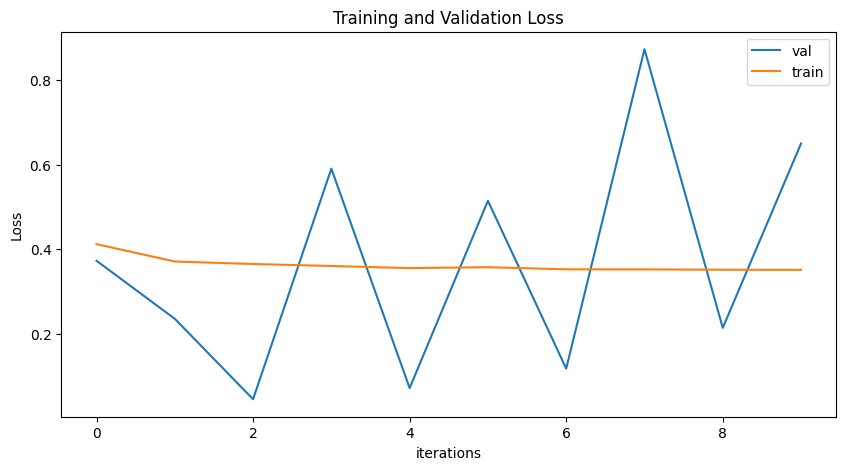

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [8]:
def process_text(text):
    lemmatizer = WordNetLemmatizer()
    punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    stop_words = stopwords.words("english")


    modified_text = text.split(":")
    if len(modified_text) > 1: text = "".join(modified_text[1:])
    else : text = modified_text[0]
    text = " ".join(text.split())
    text = str(text).lower()
    text = re.sub("[\.\,\!\?\:\;\-\=]", " ", text)
    pattern = r"^\s*"
    text = re.sub(pattern, "", text)
    text = re.sub('\rt:/g',' ',text)#r
    text = re.sub('https?://\S+|www\.\S+', '', text)#urls
    text = re.sub('\w*\d\w*', '', text)#digits
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(punctuation), '', text)
    text = re.sub('\n', '', text)
    ## remove retweets
    text = re.sub('(rt\: )|(rt\:)|(rt \: )|(rt )', ' ', text)
    text = [word for word in text.split(' ') if word not in stop_words]
    text =" ".join(text)
    text = [lemmatizer.lemmatize(word) for word in text.split(' ')]
    text =" ".join(text).lstrip()
    return text

In [9]:
text = "!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."
def IsHateSpeech(model, text):
  text = process_text(text)
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  text_encoding = tokenizer.encode_plus(text, padding='max_length', truncation=True, max_length=64, return_tensors='pt')
  input_ids = text_encoding['input_ids']
  attention_mask = text_encoding['attention_mask']
  outputs = model(input_ids, attention_mask)
  if float(outputs) <= 0.5 : return "Does not Contains Hate"
  else: return "Contains Hate"

In [10]:
print(IsHateSpeech(model, text))

Does not Contains Hate
